# Vector Overlays

- oldest GIS technique for inter-layer analysis
- associated with investigation of cholera in London in the mid-19th century
- applies to vector and raster data
- uses set operations

![](images/vo1.png)

>Compare postal code areas in Helsinki city center and a 3km buffer around the railway center

In [2]:
import geopandas as gpd 

postal_areas = gpd.read_file("data/ch6/Helsinki/Helsinki_centre_postal_areas.gpkg")
railway_station = gpd.read_file("data/ch6/Helsinki/Helsinki_railway_station.gpkg")

print(postal_areas.head())
print(f"\n{postal_areas.shape=}\n")
print(railway_station.head())

  posti_alue  ...                                           geometry
0      00100  ...  MULTIPOLYGON (((385653.893 6671591.048, 385573...
1      00120  ...  MULTIPOLYGON (((385316.092 6671076.984, 385279...
2      00130  ...  MULTIPOLYGON (((386212.111 6671061.262, 386176...
3      00140  ...  MULTIPOLYGON (((386577.05 6670280.544, 386552....
4      00150  ...  MULTIPOLYGON (((384846.102 6669565.816, 384823...

[5 rows x 5 columns]

postal_areas.shape=(30, 5)

                       name  id                        geometry
0  Helsinki Railway station   0  POINT (385738.777 6672297.759)


In [3]:
postal_areas.columns

Index(['posti_alue', 'he_vakiy', 'index_right', 'density', 'geometry'], dtype='object')

In [5]:
assert postal_areas.crs == railway_station.crs, "They don't match"

## Create a buffer around the station

In [6]:
station_buffer = railway_station.copy()
station_buffer["geometry"] = station_buffer.buffer(3000)

In [7]:
print(station_buffer.head())

                       name  ...                                           geometry
0  Helsinki Railway station  ...  POLYGON ((388738.777 6672297.759, 388724.331 6...

[1 rows x 3 columns]


In [8]:
import contextily as ctx

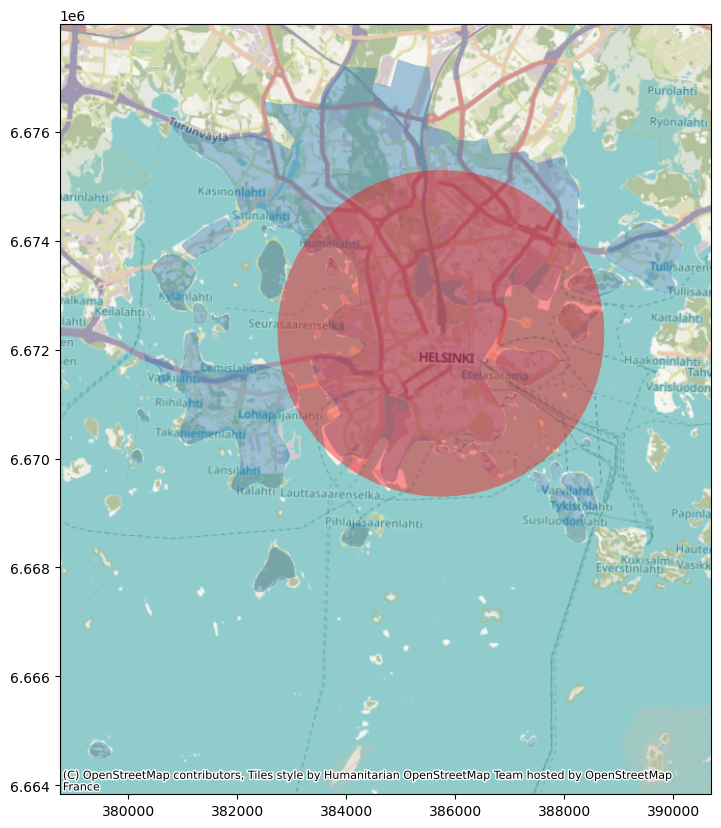

In [12]:
ax = postal_areas.plot(figsize=(12,10), alpha=0.4)
ax = station_buffer.plot(ax=ax, color='red', alpha=0.4)
ctx.add_basemap(ax, crs=postal_areas.crs);

In [13]:
station_buffer.bounds

,minx,miny,maxx,maxy
0,382738.776908,6.669298e+06,388738.776908,6.675298e+06


In [24]:
w, s, e, n = station_buffer.total_bounds

In [25]:
w

382738.7769082199

## Intersection

`overlay()` takes `how`:
- `intersection`
- `union`
- `symmetric_difference`
- `difference`
- `identity`

Note: `sjoin()` preserves input geometries, `overlay()` modifies them by cutting border areas

In [27]:
intersection = postal_areas.overlay(station_buffer, how="intersection")
print(intersection.head())
print(intersection.shape)

  posti_alue  he_vakiy  ...  id                                           geometry
0      00100   18284.0  ...   0  POLYGON ((385573.62 6671699.801, 385612.659 66...
1      00120    7108.0  ...   0  POLYGON ((385279.612 6671123.567, 385255.478 6...
2      00130    1508.0  ...   0  POLYGON ((386176.826 6671111.888, 386039.154 6...
3      00140    7865.0  ...   0  MULTIPOLYGON (((386552.849 6670283.51, 386528....
4      00150    9496.0  ...   0  MULTIPOLYGON (((384823.503 6669566.95, 384799....

[5 rows x 7 columns]
(23, 7)


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_vector_overlay(gdf1, gdf2, result, title):
    """
    Creates two maps next to each other based on `gdf1`, `gdf2` and the
    `result` GeoDataFrames.
    """

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

    ax1 = gdf1.plot(ax=ax1)
    ax1 = gdf2.plot(ax=ax1, color="red", alpha=0.3)

    result.plot(ax=ax2)

    # Fetch bounds and apply to axis 2
    xmin, ymin, xmax, ymax = gdf1.total_bounds

    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(ymin, ymax)

    fig.suptitle(title, fontsize=16)
    # Add an arrow between the plots
    fig.text(0.49, 0.5, "⇨", fontsize=30, color="red")
    ax1.axis("off")
    ax2.axis("off")
    plt.tight_layout()
    return fig, ax1, ax2

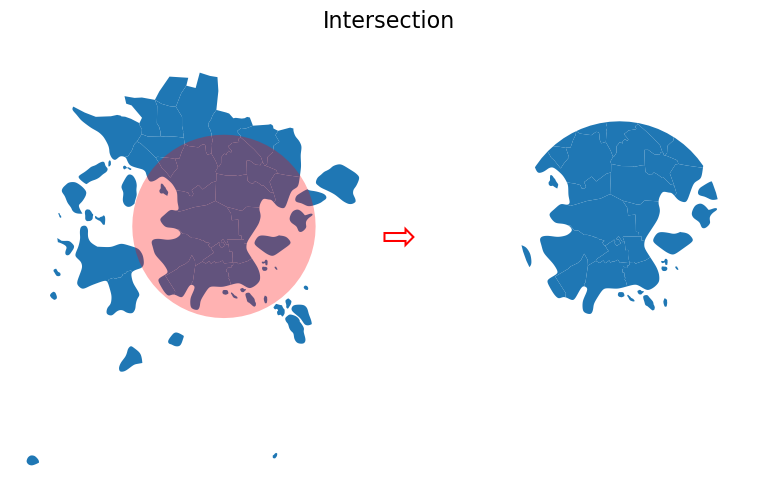

In [29]:
fig, ax1, ax2 = plot_vector_overlay(
    gdf1=postal_areas, gdf2=station_buffer, 
    result=intersection, title="Intersection"
)

## Union

Modifies the input geometries, postal areas which cross the border are split in 2

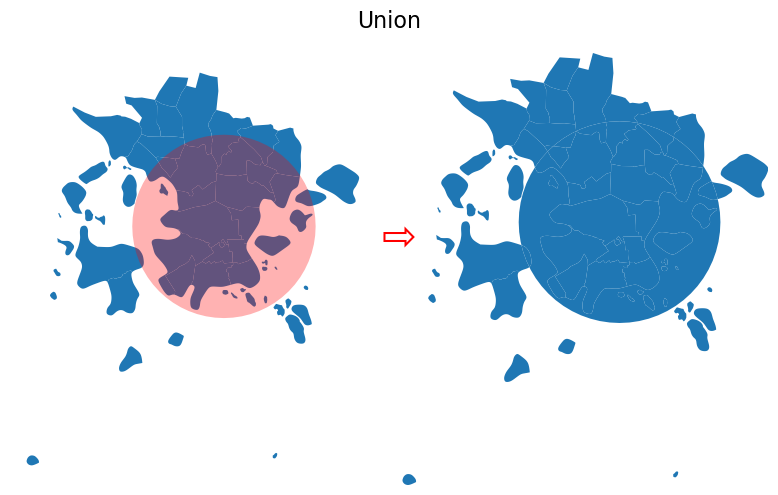

In [31]:
union = postal_areas.overlay(station_buffer, how="union")
fig, ax1, ax2 = plot_vector_overlay(
    gdf1=postal_areas, gdf2=station_buffer, 
    result=union, title="Union"
)

In [32]:
union.shape

(42, 7)

## Difference and symmetric difference

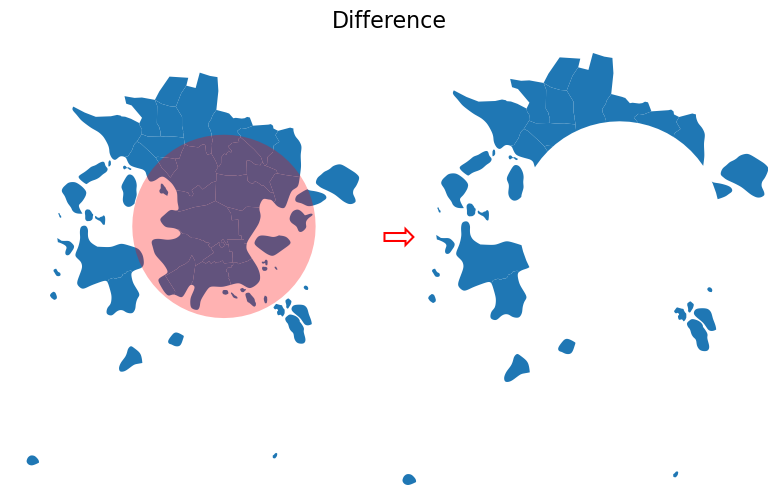

In [34]:
difference = postal_areas.overlay(station_buffer, how="difference")

fig, ax1, ax2 = plot_vector_overlay(
    gdf1=postal_areas, gdf2=station_buffer, result=difference, title="Difference"
)

In [35]:
difference.columns.values

array(['posti_alue', 'he_vakiy', 'index_right', 'density', 'geometry'],
      dtype=object)

In [36]:
difference.columns

Index(['posti_alue', 'he_vakiy', 'index_right', 'density', 'geometry'], dtype='object')

In [37]:
difference.shape

(18, 5)

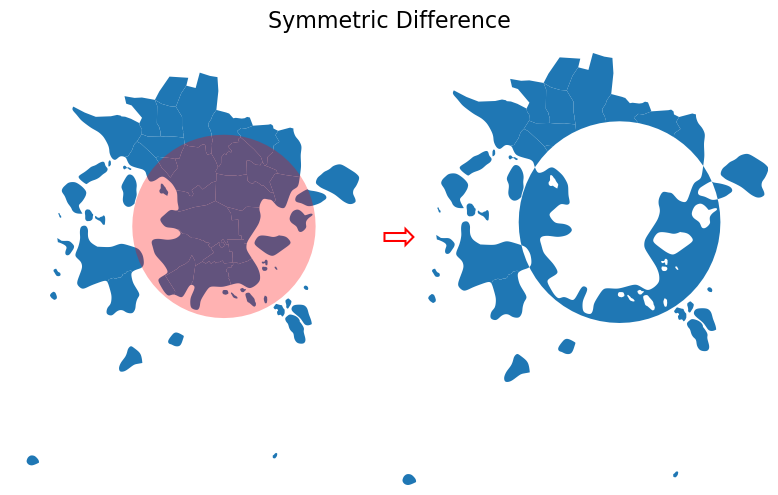

In [38]:
symmetric_difference = postal_areas.overlay(station_buffer, how="symmetric_difference")

fig, ax1, ax2 = plot_vector_overlay(
    gdf1=postal_areas,
    gdf2=station_buffer,
    result=symmetric_difference,
    title="Symmetric Difference",
)

In [39]:
print(f"{symmetric_difference.columns}\n")
print(f"{symmetric_difference.shape}\n")
print(f"{symmetric_difference.tail()}\n")

Index(['posti_alue', 'he_vakiy', 'index_right', 'density', 'name', 'id',
       'geometry'],
      dtype='object')

(19, 7)

   posti_alue  he_vakiy  ...   id                                           geometry
14      00520    7306.0  ...  NaN  POLYGON ((385333.465 6675315.885, 385335.052 6...
15      00550    9464.0  ...  NaN  POLYGON ((386285.241 6675258.417, 386164.283 6...
16      00570    3962.0  ...  NaN  MULTIPOLYGON (((389839.918 6673030.501, 389808...
17      00580    2727.0  ...  NaN  POLYGON ((387366.285 6674940.194, 387550.714 6...
18        NaN       NaN  ...  0.0  MULTIPOLYGON (((383835.597 6669978.727, 383617...

[5 rows x 7 columns]



## Identity

- Includes attributes from both sets
- Splits geometries in left set along boundaries
- Does not include geometries for right set

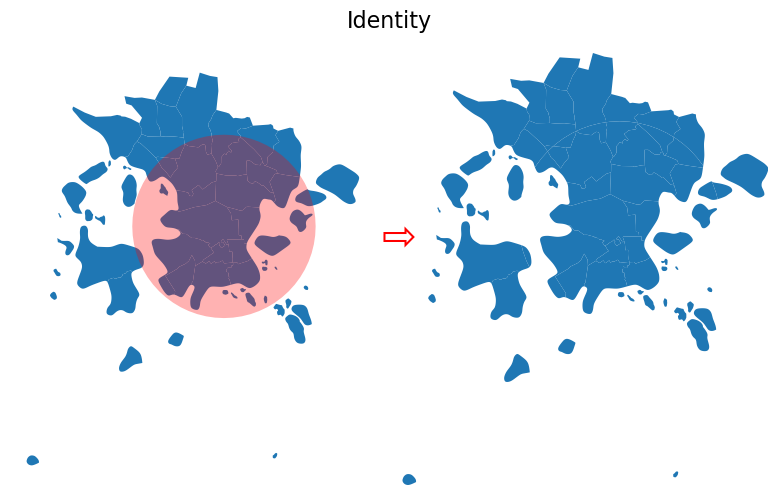

In [40]:
identity = postal_areas.overlay(station_buffer, how="identity")

fig, ax1, ax2 = plot_vector_overlay(
    gdf1=postal_areas, gdf2=station_buffer, result=identity, title="Identity"
)

In [41]:
print(f"{identity.columns}\n")
print(f"{identity.shape}\n")
print(f"{identity.loc[20:25]}\n")

Index(['posti_alue', 'he_vakiy', 'index_right', 'density', 'name', 'id',
       'geometry'],
      dtype='object')

(41, 7)

   posti_alue  he_vakiy  ...   id                                           geometry
20      00550    9464.0  ...  0.0  POLYGON ((387057.865 6674284.968, 387045.245 6...
21      00570    3962.0  ...  0.0  MULTIPOLYGON (((388536.474 6672959.818, 388512...
22      00580    2727.0  ...  0.0  POLYGON ((387749.472 6673979.696, 387491.215 6...
23      00140    7865.0  ...  NaN  POLYGON ((387352.067 6664714.928, 387339.366 6...
24      00150    9496.0  ...  NaN  POLYGON ((384180.692 6668373.742, 384154.302 6...
25      00190     743.0  ...  NaN  MULTIPOLYGON (((388259.682 6668460.022, 388233...

[6 rows x 7 columns]

